<h1> Generative Adversarial Network</h1>

In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline



Now  we'll import MNIST dataset

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("datasets_lib/mnist/")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting datasets_lib/mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting datasets_lib/mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting datasets_lib/mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting datasets_lib/mnist/t10k-labels-idx1-ubyte.gz


In [7]:
x_train = mnist.train.images[:55000,:]
x_train.shape

(55000, 784)

In [8]:
def conv2d(x, W):
    return tf.nn.conv2d(input=x, filter=W, strides=[1, 1, 1, 1], padding='SAME')

def avg_pool_2x2(x):
    return tf.nn.avg_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [9]:
def discriminator(x_image, reuse=False):
    with tf.variable_scope('discriminator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        
        W_conv1 = tf.get_variable('d_wconv1', [5, 5, 1, 8], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv1 = tf.get_variable('d_bconv1', [8], initializer=tf.constant_initializer(0))
        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        h_pool1 = avg_pool_2x2(h_conv1)

        
        W_conv2 = tf.get_variable('d_wconv2', [5, 5, 8, 16], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_conv2 = tf.get_variable('d_bconv2', [16], initializer=tf.constant_initializer(0))
        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        h_pool2 = avg_pool_2x2(h_conv2)

        #First Fully Connected Layer
        W_fc1 = tf.get_variable('d_wfc1', [7 * 7 * 16, 32], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc1 = tf.get_variable('d_bfc1', [32], initializer=tf.constant_initializer(0))
        h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*16])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

        #Second Fully Connected Layer
        W_fc2 = tf.get_variable('d_wfc2', [32, 1], initializer=tf.truncated_normal_initializer(stddev=0.02))
        b_fc2 = tf.get_variable('d_bfc2', [1], initializer=tf.constant_initializer(0))

        
        y_conv=(tf.matmul(h_fc1, W_fc2) + b_fc2)
    return y_conv

In [10]:
def generator(z, batch_size, z_dim, reuse=False):
    with tf.variable_scope('generator') as scope:
        if (reuse):
            tf.get_variable_scope().reuse_variables()
        g_dim = 64 #Number of filters of first layer of generator
        c_dim = 1 #Color dimension of output (MNIST is grayscale, so c_dim = 1 for us)
        s = 28 #Output size of the image
        # (14, 7, 3, 1)
        s2, s4, s8, s16 = int(s/2), int(s/4), int(s/8), int(s/16) #We want to slowly upscale the image, so these values will help
        h0 = tf.reshape(z, [batch_size, s16+1, s16+1, 25])
        h0 = tf.nn.relu(h0) #Dimensions of h0 = batch_size x 2 x 2 x 25
        
        #First DeConv Layer
        output1_shape = [batch_size, s8, s8, g_dim*4]
        W_conv1 = tf.get_variable('g_wconv1', [5, 5, output1_shape[-1], int(h0.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv1 = tf.get_variable('g_bconv1', [output1_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv1 = tf.nn.conv2d_transpose(h0, W_conv1, output_shape=output1_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv1 = tf.contrib.layers.batch_norm(inputs = H_conv1, center=True, scale=True, is_training=True, scope="g_bn1")
        H_conv1 = tf.nn.relu(H_conv1)
        #Dimensions of H_conv1 = batch_size x 3 x 3 x 256

        #Second DeConv Layer
        output2_shape = [batch_size, s4 - 1, s4 - 1, g_dim*2]
        W_conv2 = tf.get_variable('g_wconv2', [5, 5, output2_shape[-1], int(H_conv1.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv2 = tf.get_variable('g_bconv2', [output2_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv2 = tf.nn.conv2d_transpose(H_conv1, W_conv2, output_shape=output2_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv2 = tf.contrib.layers.batch_norm(inputs = H_conv2, center=True, scale=True, is_training=True, scope="g_bn2")
        H_conv2 = tf.nn.relu(H_conv2)
        #Dimensions of H_conv2 = batch_size x 6 x 6 x 128

        #Third DeConv Layer
        output3_shape = [batch_size, s2 - 2, s2 - 2, g_dim*1]
        W_conv3 = tf.get_variable('g_wconv3', [5, 5, output3_shape[-1], int(H_conv2.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv3 = tf.get_variable('g_bconv3', [output3_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv3 = tf.nn.conv2d_transpose(H_conv2, W_conv3, output_shape=output3_shape, strides=[1, 2, 2, 1], padding='SAME')
        H_conv3 = tf.contrib.layers.batch_norm(inputs = H_conv3, center=True, scale=True, is_training=True, scope="g_bn3")
        H_conv3 = tf.nn.relu(H_conv3)
        #Dimensions of H_conv3 = batch_size x 12 x 12 x 64

        #Fourth DeConv Layer
        output4_shape = [batch_size, s, s, c_dim]
        W_conv4 = tf.get_variable('g_wconv4', [5, 5, output4_shape[-1], int(H_conv3.get_shape()[-1])], 
                                  initializer=tf.truncated_normal_initializer(stddev=0.1))
        b_conv4 = tf.get_variable('g_bconv4', [output4_shape[-1]], initializer=tf.constant_initializer(.1))
        H_conv4 = tf.nn.conv2d_transpose(H_conv3, W_conv4, output_shape=output4_shape, strides=[1, 2, 2, 1], padding='VALID')
        H_conv4 = tf.nn.tanh(H_conv4)
        #Dimensions of H_conv4 = batch_size x 28 x 28 x 1

    return H_conv4
        
        

Generating an image . Note that adding a [None,z_dims]  in placeholder let us decide the batch_size in runtime

In [11]:
sess = tf.Session()
z_dimensions = 100
z_test_placeholder = tf.placeholder(tf.float32, [None, z_dimensions])

In [12]:
sample_image = generator(z_test_placeholder, 1, z_dimensions)
test_z = np.random.normal(-1, 1, [1,z_dimensions])

In [13]:
sess.run(tf.global_variables_initializer())
temp = (sess.run(sample_image, feed_dict={z_test_placeholder: test_z}))

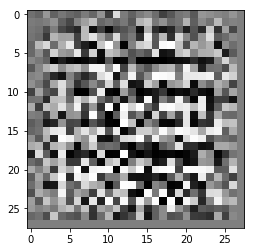

In [14]:
my_i = temp.squeeze()
plt.imshow(my_i, cmap='gray_r')
plt.show()

In [42]:
batch_size = 16
tf.reset_default_graph() #Since we changed our batch size (from 1 to 16), we need to reset our Tensorflow graph

sess = tf.Session()
x_placeholder = tf.placeholder("float", shape = [None,28,28,1]) #Placeholder for input images to the discriminator
z_placeholder = tf.placeholder(tf.float32, [None, z_dimensions]) #Placeholder for input noise vectors to the generator

The most tricky part with GAN is loss funtion. Gan is more like a min-max game , rather than a simple MSE.
This means that we need to formulate loss functions that affect both networks.

In [43]:
Dx = discriminator(x_placeholder) #Dx will hold discriminator outputs (unnormalized) for the real MNIST images
Gz = generator(z_placeholder, batch_size, z_dimensions) #Gz holds the generated images
Dg = discriminator(Gz, reuse=True) #Dg will hold discriminator outputs (unnormalized) for generated images

In [44]:
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

In [45]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))
d_loss = d_loss_real + d_loss_fake

Once we have our 2 loss functions (d_loss and g_loss), we need to define our optimizers. Keep in mind that the optimizer for the generator network needs to only update the generator’s weights, not those of the discriminator. In order to make this distinction, we need to create 2 lists, one with the discriminator’s weights and one with the generator’s weights. This is where naming all of your Tensorflow variables can come in handy.

In [46]:
tvars = tf.trainable_variables()
d_vars = [var for var in tvars if 'd_' in var.name]
g_vars = [var for var in tvars if 'g_' in var.name]

In [47]:
with tf.variable_scope(tf.get_variable_scope(), reuse=False):
    trainerD = tf.train.AdamOptimizer(0.002).minimize(d_loss, var_list=d_vars)
    trainerG = tf.train.AdamOptimizer(0.002).minimize(g_loss, var_list=g_vars)

Epoch: 0


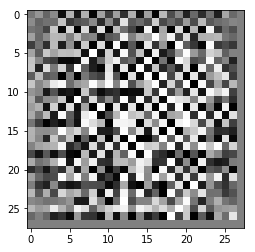

Epoch: 100


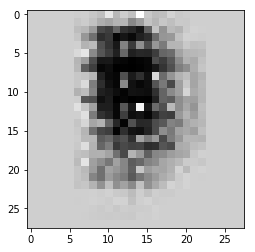

Epoch: 200


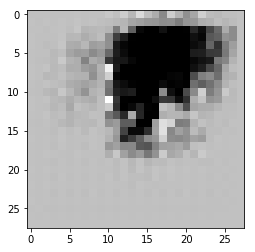

Epoch: 300


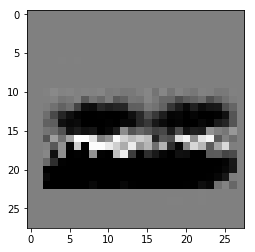

Epoch: 400


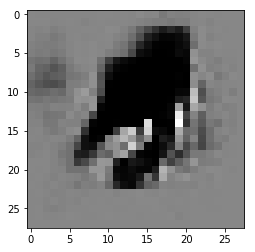

Epoch: 500


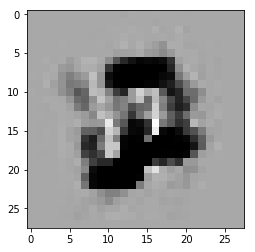

Epoch: 600


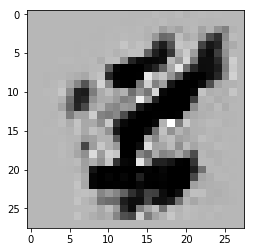

Epoch: 700


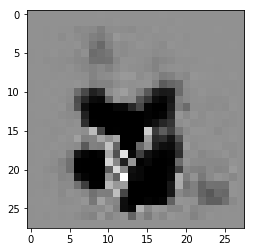

Epoch: 800


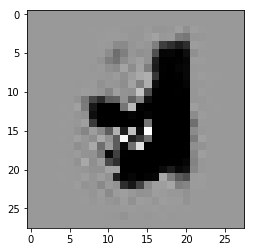

Epoch: 900


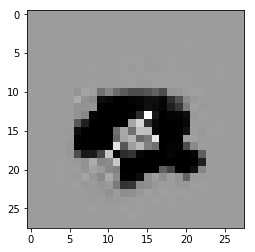

Epoch: 1000


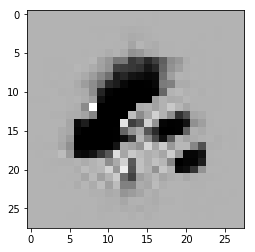

Epoch: 1100


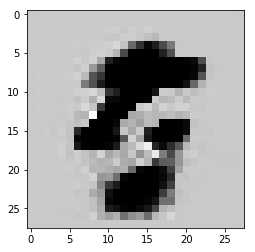

Epoch: 1200


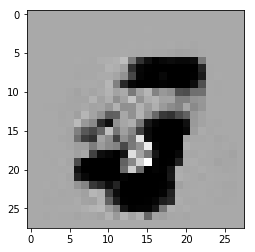

Epoch: 1300


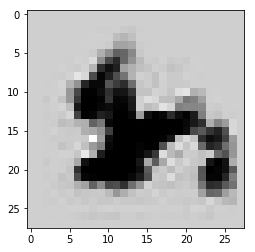

Epoch: 1400


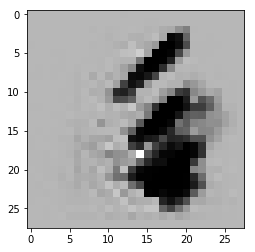

Epoch: 1500


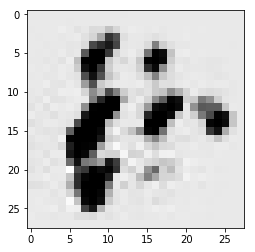

Epoch: 1600


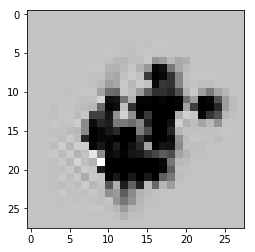

Epoch: 1700


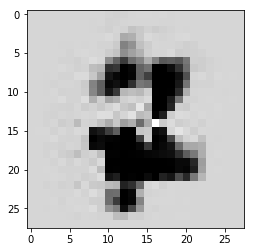

Epoch: 1800


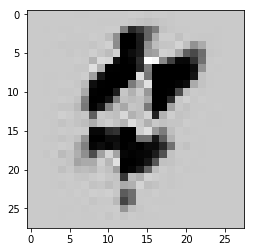

Epoch: 1900


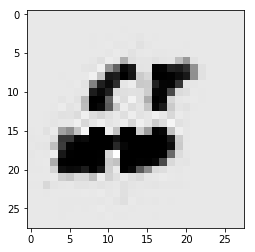

Epoch: 2000


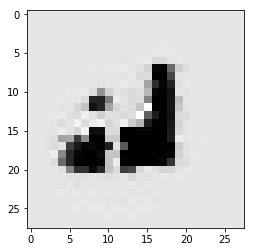

Epoch: 2100


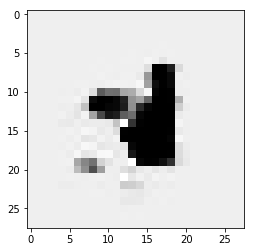

Epoch: 2200


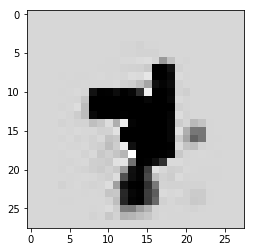

Epoch: 2300


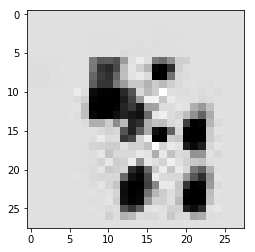

Epoch: 2400


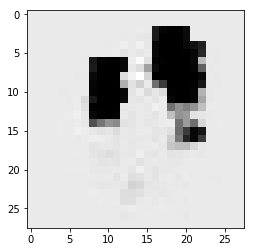

Epoch: 2500


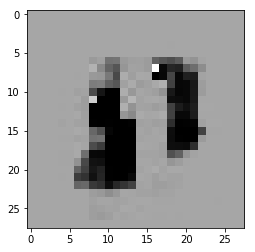

Epoch: 2600


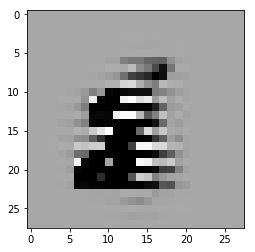

Epoch: 2700


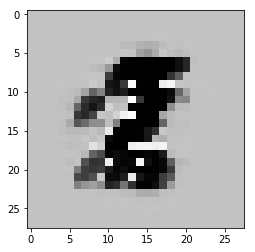

Epoch: 2800


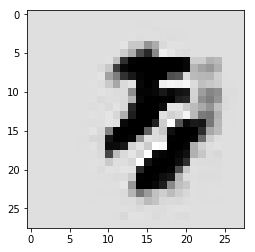

Epoch: 2900


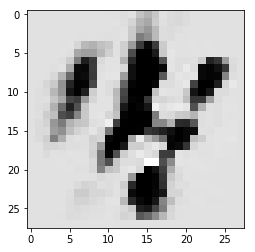

In [59]:
sess.run(tf.global_variables_initializer())
iterations = 3000
for i in range(iterations):
    if i % 100==0:
        print "Epoch:",i
        sample_image = generator(z_placeholder, 1, z_dimensions, reuse=True)
        z_batch = np.random.normal(-1, 1, size=[1, z_dimensions])
        #print z_batch
        temp = (sess.run(sample_image, feed_dict={z_placeholder: z_batch}))
        my_i = temp.squeeze()
        plt.figure()
        plt.imshow(my_i, cmap='gray_r')
        plt.show()
        
    z_batch = np.random.normal(-1, 1, size=[batch_size, z_dimensions])
    real_image_batch = mnist.train.next_batch(batch_size)
    real_image_batch = np.reshape(real_image_batch[0],[batch_size,28,28,1])
    _,dLoss = sess.run([trainerD, d_loss],feed_dict={z_placeholder:z_batch,x_placeholder:real_image_batch}) #Update the discriminator
    _,gLoss = sess.run([trainerG,g_loss],feed_dict={z_placeholder:z_batch}) #Update the generator